In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import pickle
import json

### Pre-processing 
- Removal of 'area_type', 'society', 'availability', 'balcony' columns
- Removal of rows with empty cells


In [58]:
df1 = pd.read_csv("house.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [59]:
df1.shape

(13320, 9)

In [60]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [61]:
df2 = df1.drop(['area_type', 'society', 'availability', 'balcony'], axis = 1)
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [62]:
df2.isnull().values.any()

True

In [63]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [64]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [65]:
df3.shape

(13246, 5)

### Feature Engineering
- Extrapolating a numerical value from "size" to then add a "bedrooms" column
- Standardizing "total_sqft" column features to be float values (instead of ranges)
- Addition of 'price_per_sqft' column through the division of price by sqft (land area)
- Removal of 'location' instances that appeared less than 10 times throughout the dataset

In [66]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [67]:
df3["bedrooms"] = df3["size"].apply(lambda x: int(x.split(' ')[0]))

/var/folders/9c/606k5v6x5gv640dxt5lq8j0h0000gn/T/ipykernel_21552/2494829056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["bedrooms"] = df3["size"].apply(lambda x: int(x.split(' ')[0]))


In [68]:
df3.head()

,location,size,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [69]:
df3["bedrooms"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [70]:
df3.query('bedrooms > 20')

,location,size,total_sqft,bath,price,bedrooms
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [71]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [72]:
def isfloat(x):
    try:
        float(x)
    except:
        return False
    return True 

In [73]:
df3[~df3["total_sqft"].apply(isfloat)]

,location,size,total_sqft,bath,price,bedrooms
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [74]:
def convert(x):
    numbers = x.split('-')
    if len(numbers) == 2:
        try:
            return sum(float(num) for num in numbers) / 2
        except ValueError:
            return None
    try:
        return float(numbers[0])
    except ValueError:
        return None

In [75]:
df4 = df3.copy()
df4['total_sqft'] = df3['total_sqft'].apply(convert)
df4 = df4[df4['total_sqft'].notnull()]
df4.head()

,location,size,total_sqft,bath,price,bedrooms
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [76]:
df4.shape

(13200, 6)

In [77]:
df5 = df4.copy()
#'price' was originally in "laks" ('100,000s)
df5['price_per_sqft'] = (df5['price']*100000)/df4['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [78]:
len(df5['location'].unique())

1298

In [79]:
df5['location'] = df5['location'].apply(lambda x: x.strip())
df5['location'].value_counts()

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64

In [80]:
location_freq = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
len(location_freq[location_freq<=10])

1047

In [81]:
location_freq_under_10 = location_freq[location_freq<=10]
df5['location'] = df5.location.apply(lambda x: 'other' if x in location_freq_under_10 else x)
len(df5.location.unique())

241

### Outlier Removal

In [82]:
df5.head(10)

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


Assuming 300sqft per bedroom, we remove cases where the number of bedrooms does not match this logic (smaller bedrooms)

In [83]:
df5[df5.total_sqft/df5.bedrooms<300].head()

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [84]:
df6 = df5[~(df5.total_sqft/df5.bedrooms<300)]
df6.shape

(12456, 7)

In [85]:
df6['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

We remove data that falls outside one standard deviation for the 'location' column

In [86]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

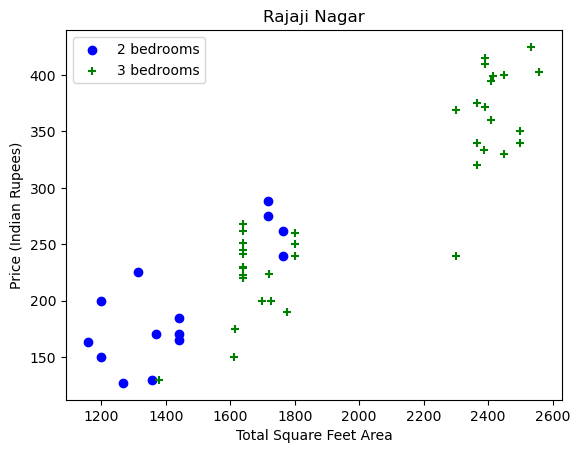

In [87]:
def plot_scatter_chart(df,location):
    b2 = df[(df.location==location) & (df.bedrooms==2)]
    b3 = df[(df.location==location) & (df.bedrooms==3)]
    plt.scatter(b2.total_sqft,b2.price,color='blue',label='2 bedrooms')
    plt.scatter(b3.total_sqft,b3.price,marker='+', color='green',label='3 bedrooms')
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

In [88]:
def remove_bedrooms_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bedrooms_stats = {}
        for bedrooms, bedrooms_df in location_df.groupby('bedrooms'):
            bedrooms_stats[bedrooms] = {
                'mean': np.mean(bedrooms_df.price_per_sqft),
                'std': np.std(bedrooms_df.price_per_sqft),
                'count': bedrooms_df.shape[0]
            }
        for bedrooms, bedrooms_df in location_df.groupby('bedrooms'):
            stats = bedrooms_stats.get(bedrooms-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bedrooms_df[bedrooms_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bedrooms_outliers(df7)
# f8 = df7.copy()
df8.shape

(7317, 7)

Text(0, 0.5, 'Count')

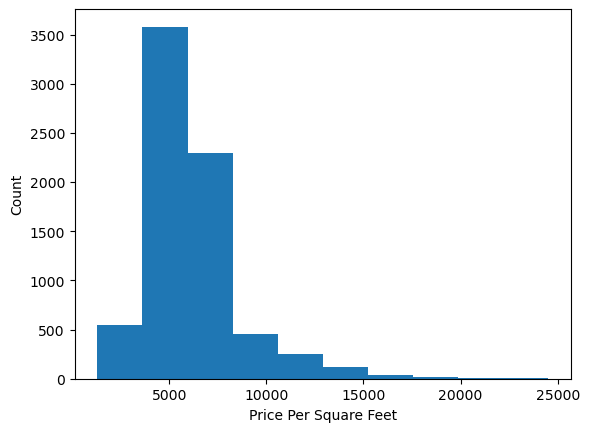

In [89]:
plt.hist(df8.price_per_sqft)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [90]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

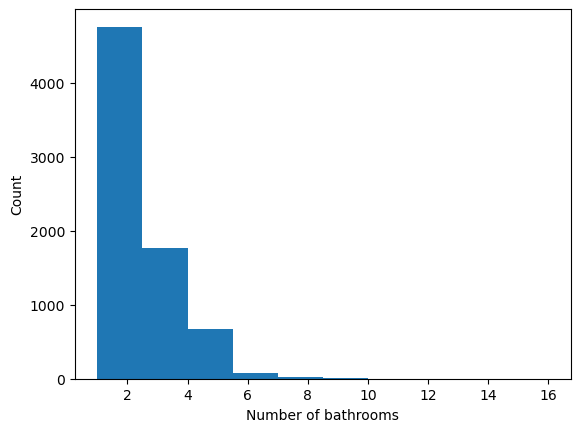

In [91]:
plt.hist(df8.bath)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [92]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [93]:
df8[df8.bath>df8.bedrooms+2]

,location,size,total_sqft,bath,price,bedrooms,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [94]:
df9 = df8[df8.bath<df8.bedrooms+2]

In [95]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bedrooms
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [96]:
df10.location = df10['location'].apply(lambda x: x.lower())
df10.head()

,location,total_sqft,bath,price,bedrooms
0,1st block jayanagar,2850.0,4.0,428.0,4
1,1st block jayanagar,1630.0,3.0,194.0,3
2,1st block jayanagar,1875.0,2.0,235.0,3
3,1st block jayanagar,1200.0,2.0,130.0,3
4,1st block jayanagar,1235.0,2.0,148.0,2


In [97]:
encoder = OneHotEncoder(sparse=False)
dummies = encoder.fit_transform(df10[['location']])
dummies_df = pd.DataFrame(dummies, columns=encoder.get_feature_names_out(['location']))
dummies = dummies_df.astype(int)
new_column_names = {col: col.split('_', 1)[1] for col in dummies.columns}
dummies.rename(columns=new_column_names, inplace=True)
dummies = dummies.astype(int)
dummies.head()




# dummies = pd.get_dummies(df10.location)
# dummies.astype(int)
# dummies.head()

/Users/mohammed/miniconda3/envs/MLenv1/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,1st block jayanagar,1st phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,5th block hbr layout,5th phase jp nagar,6th phase jp nagar,7th phase jp nagar,8th phase jp nagar,9th phase jp nagar,...,vijayanagar,vishveshwarya layout,vishwapriya layout,vittasandra,whitefield,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bedrooms,1st block jayanagar,1st phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,5th block hbr layout,...,vijayanagar,vishveshwarya layout,vishwapriya layout,vittasandra,whitefield,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yeshwanthpur
0,1st block jayanagar,2850.0,4.0,428.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1st block jayanagar,1630.0,3.0,194.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1st block jayanagar,1875.0,2.0,235.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1st block jayanagar,1200.0,2.0,130.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1st block jayanagar,1235.0,2.0,148.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
df12 = df11.drop('location',axis='columns')
df12.shape

(8729, 244)

In [100]:
x = df12.drop(['price'],axis='columns')
x.shape

(8729, 243)

In [101]:
y = df12.price
y.shape

(8729,)

In [102]:
df12.isnull().sum()

total_sqft             1490
bath                   1490
price                  1490
bedrooms               1490
1st block jayanagar    1490
                       ... 
yelachenahalli         1490
yelahanka              1490
yelahanka new town     1490
yelenahalli            1490
yeshwanthpur           1490
Length: 244, dtype: int64

In [103]:
df13 = df12.dropna()
df13.shape

(5749, 244)

In [104]:
x = df13.drop(['price'], axis='columns')
y = df13.price

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=25)

In [106]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_model.score(x_test,y_test)

0.7228460288408594

In [118]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

scores = cross_val_score(LinearRegression(), x, y, cv=cv)
print(scores)

[0.67813263 0.68141028 0.74654405]


In [117]:
best_split_index = np.argmax(scores)
print("Best split index:", best_split_index)

splits = list(cv.split(x))

best_train_indices, best_test_indices = splits[best_split_index]

x_train_best, x_test_best = x.iloc[best_train_indices], x.iloc[best_test_indices]
y_train_best, y_test_best = y.iloc[best_train_indices], y.iloc[best_test_indices]

best_lr_model = LinearRegression()
best_lr_model.fit(x_train_best, y_train_best)

best_split_score = lr_model.score(x_test_best, y_test_best)
print("Best split score:", best_split_score)

Best split index: 2
Best split score: 0.7662007718383448


In [109]:
def find_best_model_using_gridsearchcv(x,y):
    algos = {

        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['squared_error','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(x,y)

,model,best_score,best_params
0,lasso,0.687227,"{'alpha': 1, 'selection': 'random'}"
1,decision_tree,0.638495,"{'criterion': 'squared_error', 'splitter': 'ra..."


In [115]:
def predict_price(location, sqft, bath, bedrooms):    
    loc_index = np.where(x_columns == location)[0][0] if location in x_columns else -1
    
    x_input = np.zeros(len(x_columns))
    x_input[0] = sqft
    x_input[1] = bath
    x_input[2] = bedrooms

    if loc_index >= 0:
        x_input[loc_index] = 1

    return best_lr_model.predict([x_input])[0]

x_columns = np.array(x.columns)
print(x_columns.shape)

(243,)


In [119]:
predict_price('1st phase jp nagar', 1000, 2, 2)

/Users/mohammed/miniconda3/envs/MLenv1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


82.35341560190622

In [120]:
with open('model.pickle','wb') as f:
    pickle.dump(best_lr_model,f)

In [121]:
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))